The Australian DEM is 35GB, and hosted by the DEA [here](https://data.dea.ga.gov.au/?prefix=projects/elevation/ga_srtm_dem1sv1_0/)
AWS bucket name to use to access the data is `dea-public-data`

## Original Data Source

*SRTM-derived 1 Second Digital Elevation Models Version 1.0*

The 1 second Shuttle Radar Topography Mission (SRTM) Digital Elevation
Models Version 1.0 package comprises three surface models: the Digital
Elevation Model (DEM), the Smoothed Digital Elevation Model (DEM-S)
and the Hydrologically Enforced Digital Elevation Model (DEM-H).

### sources and guides
[DEA guide to accessing data from their public S3 bucket using STAC](https://docs.dea.ga.gov.au/guides/setup/gis/stac/)

[Downloading and streaming data using STAC metadata](https://docs.dea.ga.gov.au/notebooks/How_to_guides/Downloading_data_with_STAC/)

In [25]:
import os

# packages for widgets and interactive map:
import ipywidgets as widgets
from IPython.display import display, HTML
from ipyleaflet import Map, WidgetControl, GeoData
import io
import base64

#packages for geo-processing:
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import xarray as xr
import xarray_leaflet

import pystac_client
import stackstac
import odc.stac
import pyproj
from dask.distributed import Client, LocalCluster
import pandas as pd

In [2]:
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

1. Set environment variable for AWS and start a Dask client for parallel computation (needed for stackstac)
2. Read the boundary GeoJSON file and extract the bounding box
3. Open the STAC catalogs for DEM and RGB data
4. Define the collections for DEM and RGB data
5. Set the date range for the RGB data
6. Define spatial projection information

## environment and STAC setup

In [3]:
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
client = Client()
#cluster = LocalCluster()

catalog_dem = pystac_client.Client.open("https://explorer.sandbox.dea.ga.gov.au/stac/")
collection_dem = ['ga_srtm_dem1sv1_0']

start_date = "2023-01-01"
end_date = "2023-02-01"

crs_string = "epsg:3857"
epsg = pyproj.CRS.from_string(crs_string).to_epsg()
resolution = 90 #added to resolve error "Failed to auto-guess CRS/resolution."


## interactive map so users can upload aoi files

In [ ]:
style = {'description_width': 'initial'}
uploader = widgets.FileUpload(
    description='Upload file',
    accept='.zip, .json, .geojson',
    multiple=False,
    button_style='primary',
    style=style,
)

submit = widgets.Button(description='Display AOI', button_style='success', tooltip='Click me', style=style)

reset = widgets.Button(description='Reset', button_style='warning', tooltip='Click me', style=style)

get_data = widgets.Button(description='Get data for AOI', button_style='primary', tooltip='Click me', style=style)


the center point and zoom of the map are currently hard coded. Need to be updated to "zoom to layer" so that the map centers on the area covered by the user-uploaded geojson.
Also note that the map center lat/long are in opposite order to how they are stored in a geojson so need to add line to swap x/y coords to be used.

In [ ]:
Map = Map(height='500px', width='500px', center=(-29.2253, 116.26012), zoom=10) #note that the center coordinates are the opposite to what is stored in a geojson, you need to swap the lat/long

output_widget = widgets.Output(layout={'border': '1px solid black'})
output_control = WidgetControl(widget=output_widget, position='bottomright')
Map.add_control(output_control)

with output_widget:
    display(uploader)
    display(submit)
    display(get_data)
    display(reset)

In [ ]:
geo_json = None

def get_vector(upload_widget):
    vector = None
    try:
        file = upload_widget.value[0]
        content = file['content']
        bytes_io = io.BytesIO(content)
        vector = gpd.read_file(bytes_io)

    except Exception as e:
        print(e)
    return vector


def submit_clicked(b):
    global geo_json
    try:
        fc = get_vector(uploader)
        geo_json = GeoData(geo_dataframe = fc)
        Map.add_layer(geo_json)
    except Exception as e:
        print(e)
    
submit.on_click(submit_clicked)


def reset_clicked(b):
    global geo_json  # Declare geo_json as global so that we can access it
    output_widget.clear_output()
    with output_widget:
        display(uploader)
        display(submit)
        display(get_data)
        display(reset)
    uploader.value.clear()
    uploader._counter = 0
    if geo_json is not None:  # If a GeoData layer has been added to the map
        Map.remove_layer(geo_json)  # Remove the GeoData layer from the map
        geo_json = None  # Reset the reference to the GeoData layer

reset.on_click(reset_clicked)


## using uploaded aoi to get DEM

Download the fetched DEM raster:

In [ ]:
#this cell is for the get_data button
def get_data(b):
    global geo_json
    bbox = list(geo_json.total_bounds)
    ds_dem = catalog_dem.search(
    bbox=bbox, 
    collections=collection_dem)

    items = ds_dem.item_collection()
    bands_of_interest = 'dem_h'

    da = stackstac.stack(
        items,
        assets=[bands_of_interest],
        epsg=epsg,
        resolution=resolution,
        bounds_latlon=bbox# <-- use Dask
    ).isel(time=0)
    da = da.compute()
    


In [ ]:

def create_download_link(df, title = "Download GeoDataFrame", filename = "data.geojson"): 
    df.to_file(filename, driver='GeoJSON')
    data = open(filename, "rb").read()
    b64 = base64.b64encode(data)
    payload = b64.decode()

    html = '<a download="{filename}" href="data:text/json;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
download_button = create_download_link(test_download)    

## This section of code uses a hardcoded geojson to test. Remove once widget version is working.

In [4]:

geom_gpd = gpd.read_file('data/temp/dissolved-boundaries.geojson')
bbox = list(geom_gpd.total_bounds)
bbox


[116.26012130269045,
 -29.307384715430175,
 116.3875862387774,
 -29.220237788279107]

Search for DEM data in the STAC catalog. Note that there is no timeframe filtering here because there is only 1, perpetual DEM in this catalog. If you add a timeframe you will get 0 results.
There are 3 assets in this collection: `dem`, `dem_s` and `dem_h`. All three are based on the NASA SRTM elevation data, so just use `dem_h`.
We will also get the url for the `dem_h` COG, so we can display it on a leafmap later on.

In [11]:
ds_dem = catalog_dem.search(
    bbox=bbox, 
    collections=collection_dem)

items = ds_dem.item_collection()
print(f"Found {len(items)} items in the {collection_dem}")

Found 1 items in the ['ga_srtm_dem1sv1_0']


In [12]:
first_item = items.items[0]
all_bands = list(first_item.assets.keys())
print("Assets available:")
print(*all_bands, sep=', ')

Assets available:
dem, dem_h, dem_s


In [20]:
bands_of_interest = 'dem_h'

da = stackstac.stack(
    items,
    assets=[bands_of_interest],
    epsg=epsg,
    resolution=resolution,
    bounds_latlon=bbox# <-- use Dask
).isel(time=0)
da


/opt/conda/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-87728d3abd58d5accb335536b977cd4a' (band: 1,
                                                                y: 125, x: 158)>
dask.array<getitem, shape=(1, 125, 158), dtype=float64, chunksize=(1, 125, 158), chunktype=numpy.ndarray>
Coordinates: (12/15)
    time                  datetime64[ns] 2014-12-15T14:58:44
    id                    <U36 '007f754d-6b3b-4a34-beaf-557c4eff2daa'
  * band                  (band) <U5 'dem_h'
  * x                     (x) float64 1.294e+07 1.294e+07 ... 1.296e+07
  * y                     (y) float64 -3.404e+06 -3.404e+06 ... -3.415e+06
    proj:epsg             int64 4326
    ...                    ...
    platform              <U23 'space shuttle endeavour'
    instruments           <U3 'sir'
    common_name           object None
    center_wavelength     object None
    full_width_half_max   object None
    epsg                  int64 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(12942000, -3414870, 12956220, ...
    crs:         epsg:3857
    transform:   | 90.00, 0.00, 12942000.00|\n| 0.00,-90.00,-3403620.00|\n| 0...
    resolution:  90

Stack the DEM data, specifying the spatial bounds and desired resolution

One thing to watch out for with stackstac.stack is that you will wind up with a distinct time coordinate for each STAC item that you pass in. To achieve the intuitive representation of the data, you need to flatten the DataArray with respect to day.
Note: if you are only reading a single STAC item, stackstac.mosaic will inadvertently reduce your data along the band dimension (which is definitely not what you want!), hence the conditional statement checking for more than one time coordinate value.
[from here](https://hrodmn.dev/posts/stackstac/)

Here we are getting around the problem by using `isel` to select the first time epoch, as there is only one. A different approach will be needed if working with data across timeframes.

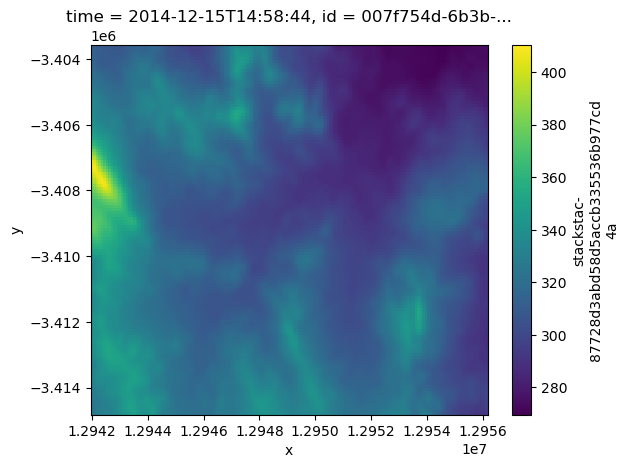

In [26]:
da = da.compute()
da.plot()

Save the selected DEM data as a GeoTIFF file

In [37]:
output_filename = "data/temp/clipped_raster.tif"
with rasterio.open(
    output_filename,
    'w',
    driver='GTiff',
    height=dem.shape[1],
    width=dem.shape[2],
    count=dem.shape[0],
    dtype=dem.dtype,
    crs=dem.crs,
    transform=dem.transform,
) as dst:
    dst.write(dem)
    

In [38]:
# Define the filename for the reprojected raster
reprojected_filename = "data/temp/reprojected_raster.tif"

# Open the original clipped raster
with rasterio.open(output_filename) as src:
    # Define the transform and dimensions for the new raster
    transform, width, height = calculate_default_transform(
        src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)
    
    # Define the metadata for the new raster
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': 'EPSG:4326',
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create and write the reprojected raster
    with rasterio.open(reprojected_filename, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs='EPSG:4326',
                resampling=Resampling.nearest)

In [39]:
dem_client = TileClient('data/temp/reprojected_raster.tif')
dem_client.thumbnail(palette="gist_earth")

NameError: name 'TileClient' is not defined

## put map cell at bottom of notebook

In [ ]:
Map

## part 2: getting RGB data over the same area as a sanity check